In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

## 1. Data Loading

Load full datasets and compute intersection datasets for all 4 metals.

In [2]:
# Define metals
metal_names = ['cobalt', 'copper', 'lithium', 'nickel']

# Load full datasets (long horizon)
print("="*60)
print("LOADING FULL DATASETS")
print("="*60 + "\n")

full_data = {}
for metal in metal_names:
    df = pd.read_csv(f'data/ALL_{metal}_prices_cubic_spline.csv', 
                     parse_dates=['Date'], index_col='Date')
    full_data[metal.capitalize()] = df
    print(f"{metal.capitalize()} (full): {df.shape[0]} rows, {df.shape[1]} series")
    print(f"  Range: {df.index.min()} to {df.index.max()}")

print("\n" + "="*60)
print("COMPUTING INTERSECTION DATASETS")
print("="*60 + "\n")

# Compute intersection datasets (short horizon)
# Find common time range where ALL series have valid data
intersection_data = {}
for metal in metal_names:
    df = full_data[metal.capitalize()].copy()
    
    # Exclude LISAME series
    if 'LISAME' in df.columns:
        df = df.drop(columns=['LISAME'])
        print(f"{metal.capitalize()}: LISAME series excluded")
    
    # Find the intersection: dates where all series have non-null values
    common_dates = df.dropna().index
    
    if len(common_dates) > 0:
        # Create intersection dataset
        df_int = df.loc[common_dates].copy()
        intersection_data[metal.capitalize()] = df_int
        
        print(f"{metal.capitalize()} (intersection):")
        print(f"  Time range: {df_int.index.min()} to {df_int.index.max()}")
        print(f"  Observations: {len(df_int)}")
        print(f"  Series: {df_int.shape[1]}")
        print(f"  Series names: {df_int.columns.tolist()}")
    else:
        print(f"{metal.capitalize()}: No common intersection found across all series!")
        # Fallback: use most recent common period
        # Find date range with maximum coverage
        coverage = df.notna().sum(axis=1)
        max_coverage = coverage.max()
        best_dates = coverage[coverage == max_coverage].index
        df_int = df.loc[best_dates].dropna(axis=1)  # Keep only complete columns
        intersection_data[metal.capitalize()] = df_int
        
        print(f"  Using fallback: maximum coverage period")
        print(f"  Time range: {df_int.index.min()} to {df_int.index.max()}")
        print(f"  Observations: {len(df_int)}")
        print(f"  Series: {df_int.shape[1]} (some series excluded)")
    
    print()

LOADING FULL DATASETS

Cobalt (full): 3876 rows, 6 series
  Range: 2012-03-02 00:00:00 to 2025-11-18 00:00:00
Copper (full): 2342 rows, 6 series
  Range: 2017-01-01 00:00:00 to 2025-12-31 00:00:00
Lithium (full): 2202 rows, 7 series
  Range: 2017-05-10 00:00:00 to 2025-12-09 00:00:00
Nickel (full): 2857 rows, 6 series
  Range: 2016-04-04 00:00:00 to 2025-11-18 00:00:00

COMPUTING INTERSECTION DATASETS

Cobalt (intersection):
  Time range: 2023-05-04 00:00:00 to 2025-07-21 00:00:00
  Observations: 662
  Series: 6
  Series names: ['CODALY', 'COLMEX', 'COLMEA', 'COWUXI', 'COCOMX', 'COSMMS']

Copper (intersection):
  Time range: 2024-03-06 00:00:00 to 2025-10-31 00:00:00
  Observations: 432
  Series: 6
  Series names: ['CUDALY', 'CUCOMX', 'CULMEX', 'CUSMMG', 'CUSHFE', 'CUETFC']

Lithium: LISAME series excluded
Lithium (intersection):
  Time range: 2023-10-02 00:00:00 to 2025-10-31 00:00:00
  Observations: 556
  Series: 6
  Series names: ['LIDALY', 'LICOMX', 'LILAMC', 'LIEALC', 'LIEABG', 'L

## 2. Helper Functions

In [3]:
def compute_spearman_matrix(df):
    """Compute Spearman correlation matrix for aligned data."""
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
    
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
            else:
                # Remove NaN values for this pair
                valid_idx = df[[col1, col2]].dropna().index
                if len(valid_idx) > 10:  # Minimum 10 observations
                    corr, _ = spearmanr(df.loc[valid_idx, col1], df.loc[valid_idx, col2])
                    corr_matrix.loc[col1, col2] = corr
                else:
                    corr_matrix.loc[col1, col2] = np.nan
    
    return corr_matrix.astype(float)


def compute_pairwise_overlap_corr(df):
    """Compute Spearman correlation for each pair using maximum overlap."""
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
    overlap_counts = pd.DataFrame(index=df.columns, columns=df.columns, dtype=int)
    
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
                overlap_counts.loc[col1, col2] = len(df[col1].dropna())
            else:
                # Find overlapping valid data
                valid_idx = df[[col1, col2]].dropna().index
                overlap_counts.loc[col1, col2] = len(valid_idx)
                
                if len(valid_idx) > 10:
                    corr, _ = spearmanr(df.loc[valid_idx, col1], df.loc[valid_idx, col2])
                    corr_matrix.loc[col1, col2] = corr
                else:
                    corr_matrix.loc[col1, col2] = np.nan
    
    return corr_matrix.astype(float), overlap_counts


def create_correlation_network(corr_matrix, title, metal_color, threshold=0.3):
    """Create network visualization from correlation matrix."""
    G = nx.Graph()
    
    # Add nodes
    for node in corr_matrix.columns:
        G.add_node(node)
    
    # Add edges for significant correlations
    edge_colors = []
    edge_widths = []
    
    for i, col1 in enumerate(corr_matrix.columns):
        for col2 in corr_matrix.columns[i+1:]:
            corr = corr_matrix.loc[col1, col2]
            if pd.notna(corr) and abs(corr) > threshold:
                G.add_edge(col1, col2, weight=abs(corr), corr=corr)
                
                # Color: green for positive, red for negative
                if corr > 0:
                    edge_colors.append('#27ae60')
                else:
                    edge_colors.append('#e74c3c')
                
                edge_widths.append(abs(corr) ** 1.5 * 8)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 12))
    
    if G.number_of_edges() > 0:
        pos = nx.spring_layout(G, k=2, iterations=100, seed=42, weight='weight')
        
        # Draw edges
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color=edge_colors)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color=metal_color, 
                              node_size=1200, alpha=0.9, linewidths=2.5, edgecolors='white')
        
        # Add labels
        nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold',
                               font_color='black', bbox=dict(boxstyle='round,pad=0.2',
                               facecolor='white', edgecolor='none', alpha=0.7))
        
        # Legend
        legend_elements = [
            plt.Line2D([0], [0], color='#27ae60', linewidth=3, label='Positive correlation'),
            plt.Line2D([0], [0], color='#e74c3c', linewidth=3, label='Negative correlation')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=11, framealpha=0.95)
    
    plt.title(title, fontsize=14, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G

## 3. Analysis by Metal

For each metal, compare short horizon (intersection-based) vs long horizon (pairwise overlap).

### 3.1 Cobalt

In [4]:
metal = 'Cobalt'
color = '#3498db'  # Blue

print(f"{'='*60}")
print(f"  {metal.upper()} - CORRELATION ANALYSIS")
print(f"{'='*60}\n")

# Short horizon (intersection)
print("SHORT HORIZON (Intersection-based)")
print("-" * 40)
df_short = intersection_data[metal].dropna()
print(f"Time range: {df_short.index.min()} to {df_short.index.max()}")
print(f"Observations: {len(df_short)}")
print(f"Series: {df_short.columns.tolist()}\n")

corr_short = compute_spearman_matrix(df_short)
print("Spearman correlation matrix (short horizon):")
print(corr_short.round(3))
print(f"\nMean correlation: {corr_short.values[np.triu_indices_from(corr_short.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_short.values[np.triu_indices_from(corr_short.values, k=1)]):.3f}\n")

# Long horizon (pairwise overlap)
print("LONG HORIZON (Pairwise overlap)")
print("-" * 40)
df_long = full_data[metal]
print(f"Full dataset range: {df_long.index.min()} to {df_long.index.max()}")
print(f"Total rows: {len(df_long)}\n")

corr_long, overlap_counts = compute_pairwise_overlap_corr(df_long)
print("Spearman correlation matrix (long horizon - pairwise overlap):")
print(corr_long.round(3))
print(f"\nMean correlation: {corr_long.values[np.triu_indices_from(corr_long.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_long.values[np.triu_indices_from(corr_long.values, k=1)]):.3f}")

print("\nOverlap counts (observations per pair):")
print(overlap_counts)

  COBALT - CORRELATION ANALYSIS

SHORT HORIZON (Intersection-based)
----------------------------------------
Time range: 2023-05-04 00:00:00 to 2025-07-21 00:00:00
Observations: 662
Series: ['CODALY', 'COLMEX', 'COLMEA', 'COWUXI', 'COCOMX', 'COSMMS']

Spearman correlation matrix (short horizon):
        CODALY  COLMEX  COLMEA  COWUXI  COCOMX  COSMMS
CODALY   1.000   0.988  -0.134   0.869   0.920   0.898
COLMEX   0.988   1.000  -0.130   0.858   0.912   0.887
COLMEA  -0.134  -0.130   1.000  -0.134  -0.137  -0.007
COWUXI   0.869   0.858  -0.134   1.000   0.895   0.926
COCOMX   0.920   0.912  -0.137   0.895   1.000   0.909
COSMMS   0.898   0.887  -0.007   0.926   0.909   1.000

Mean correlation: 0.568
Median correlation: 0.887

LONG HORIZON (Pairwise overlap)
----------------------------------------
Full dataset range: 2012-03-02 00:00:00 to 2025-11-18 00:00:00
Total rows: 3876

Spearman correlation matrix (long horizon - pairwise overlap):
        CODALY  COLMEX  COLMEA  COWUXI  COCOMX  C


COBALT VISUALIZATIONS



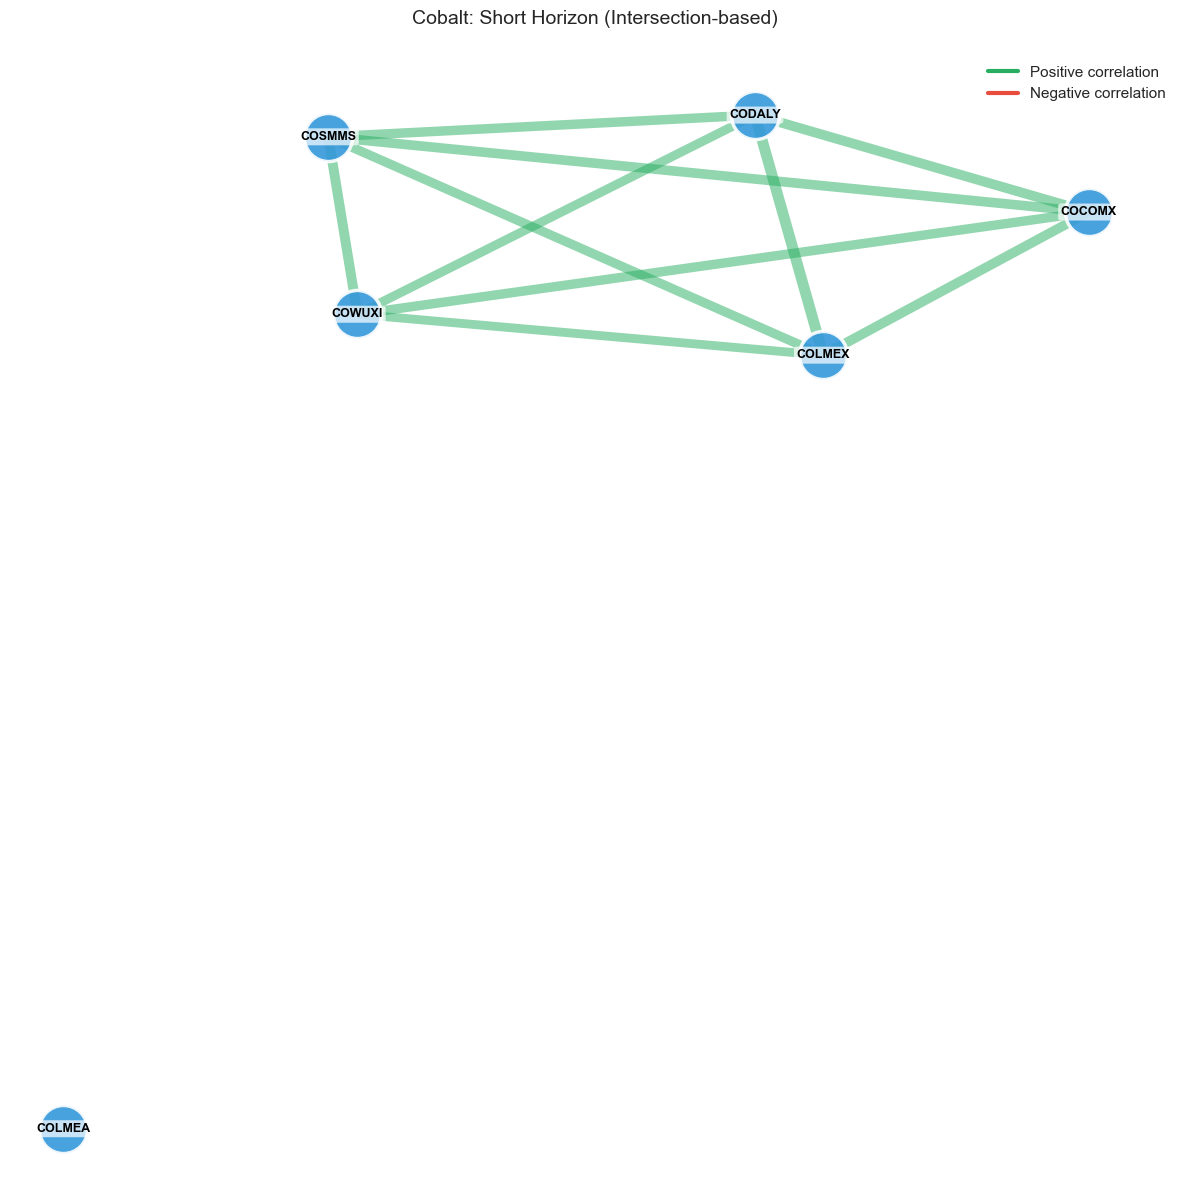

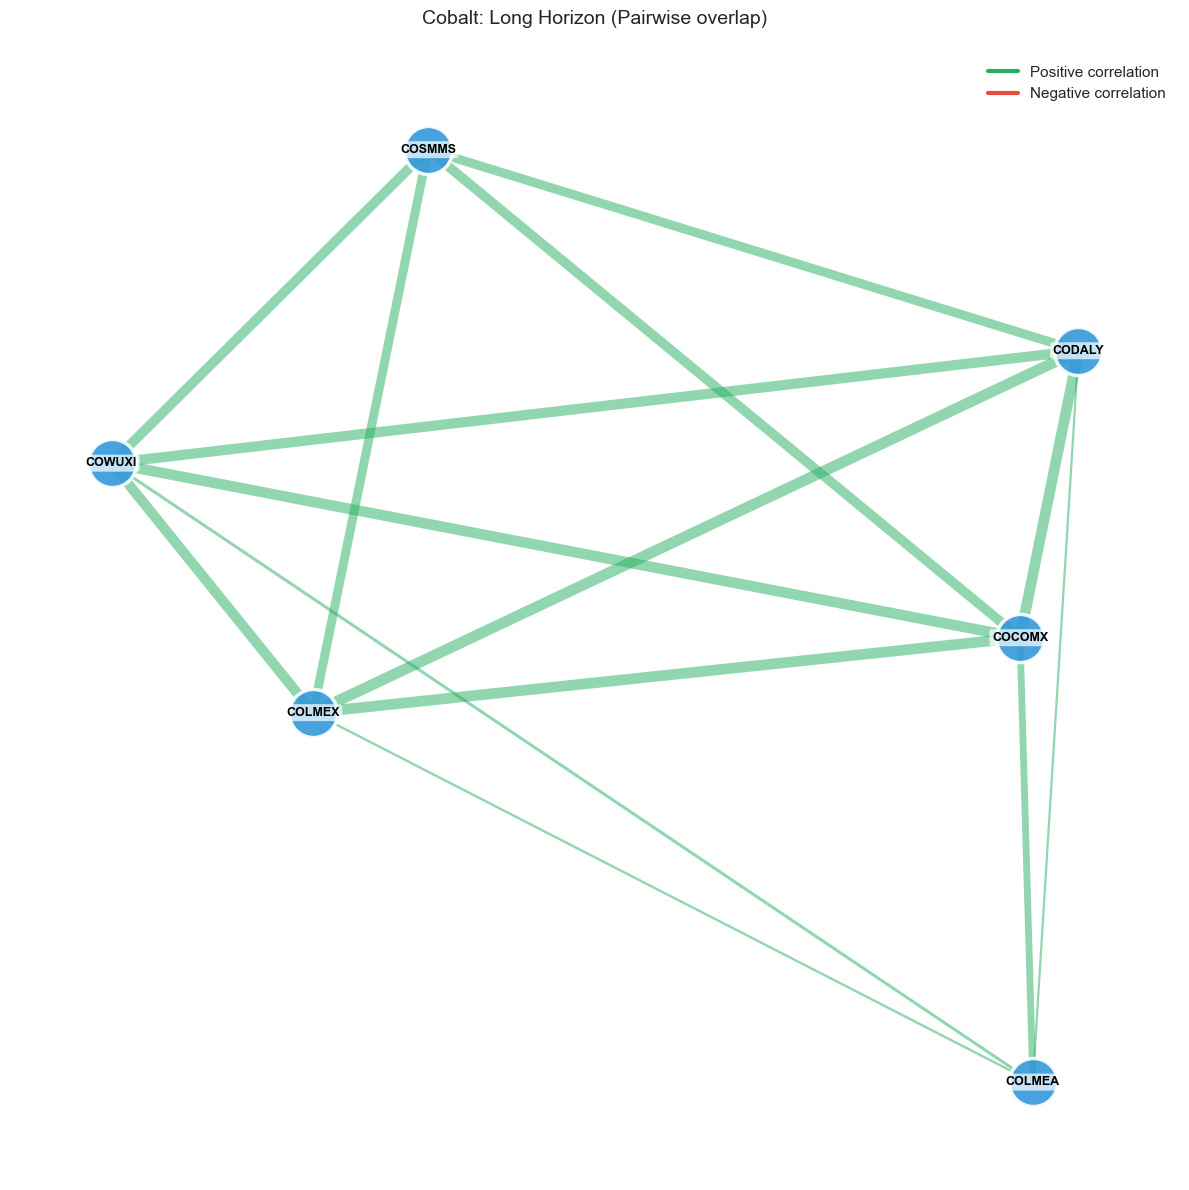

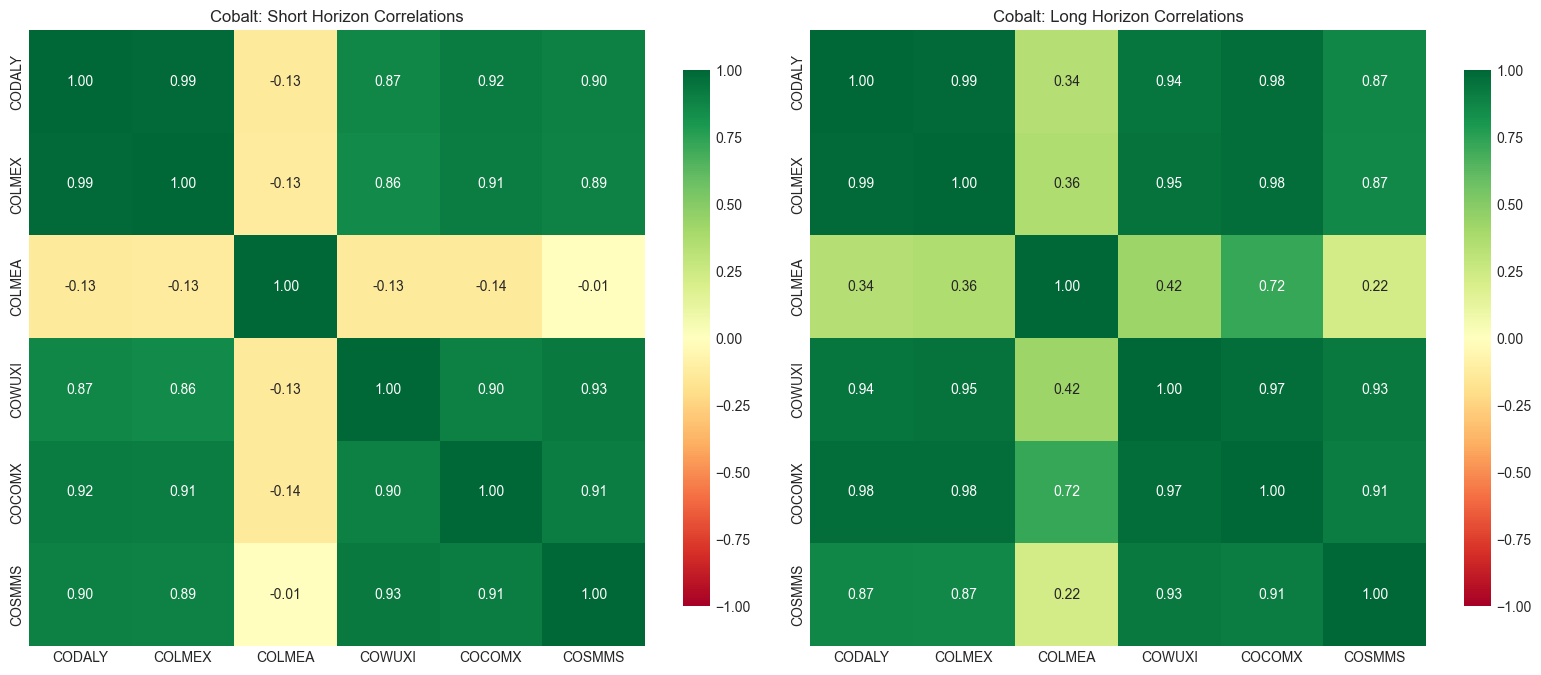

In [5]:
# Visualizations for Cobalt
print("\n" + "="*60)
print("COBALT VISUALIZATIONS")
print("="*60 + "\n")

G_short = create_correlation_network(corr_short, 
                                     f'{metal}: Short Horizon (Intersection-based)',
                                     color, threshold=0.3)

G_long = create_correlation_network(corr_long,
                                    f'{metal}: Long Horizon (Pairwise overlap)',
                                    color, threshold=0.3)

# Comparison heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_short, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            vmin=-1, vmax=1, square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title(f'{metal}: Short Horizon Correlations', fontsize=12)

sns.heatmap(corr_long, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title(f'{metal}: Long Horizon Correlations', fontsize=12)

plt.tight_layout()
plt.show()

### 3.2 Copper

In [6]:
metal = 'Copper'
color = '#e67e22'  # Orange

print(f"{'='*60}")
print(f"  {metal.upper()} - CORRELATION ANALYSIS")
print(f"{'='*60}\n")

# Short horizon
print("SHORT HORIZON (Intersection-based)")
print("-" * 40)
df_short = intersection_data[metal].dropna()
print(f"Time range: {df_short.index.min()} to {df_short.index.max()}")
print(f"Observations: {len(df_short)}")
print(f"Series: {df_short.columns.tolist()}\n")

corr_short = compute_spearman_matrix(df_short)
print("Spearman correlation matrix (short horizon):")
print(corr_short.round(3))
print(f"\nMean correlation: {corr_short.values[np.triu_indices_from(corr_short.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_short.values[np.triu_indices_from(corr_short.values, k=1)]):.3f}\n")

# Long horizon
print("LONG HORIZON (Pairwise overlap)")
print("-" * 40)
df_long = full_data[metal]
print(f"Full dataset range: {df_long.index.min()} to {df_long.index.max()}")
print(f"Total rows: {len(df_long)}\n")

corr_long, overlap_counts = compute_pairwise_overlap_corr(df_long)
print("Spearman correlation matrix (long horizon - pairwise overlap):")
print(corr_long.round(3))
print(f"\nMean correlation: {corr_long.values[np.triu_indices_from(corr_long.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_long.values[np.triu_indices_from(corr_long.values, k=1)]):.3f}")

print("\nOverlap counts (observations per pair):")
print(overlap_counts)

  COPPER - CORRELATION ANALYSIS

SHORT HORIZON (Intersection-based)
----------------------------------------
Time range: 2024-03-06 00:00:00 to 2025-10-31 00:00:00
Observations: 432
Series: ['CUDALY', 'CUCOMX', 'CULMEX', 'CUSMMG', 'CUSHFE', 'CUETFC']

Spearman correlation matrix (short horizon):
        CUDALY  CUCOMX  CULMEX  CUSMMG  CUSHFE  CUETFC
CUDALY   1.000   0.998  -0.029  -0.001   0.834   0.173
CUCOMX   0.998   1.000  -0.016   0.011   0.837   0.182
CULMEX  -0.029  -0.016   1.000   0.963   0.082   0.226
CUSMMG  -0.001   0.011   0.963   1.000   0.118   0.122
CUSHFE   0.834   0.837   0.082   0.118   1.000   0.507
CUETFC   0.173   0.182   0.226   0.122   0.507   1.000

Mean correlation: 0.334
Median correlation: 0.173

LONG HORIZON (Pairwise overlap)
----------------------------------------
Full dataset range: 2017-01-01 00:00:00 to 2025-12-31 00:00:00
Total rows: 2342

Spearman correlation matrix (long horizon - pairwise overlap):
        CUDALY  CUCOMX  CULMEX  CUSMMG  CUSHFE  C


COPPER VISUALIZATIONS



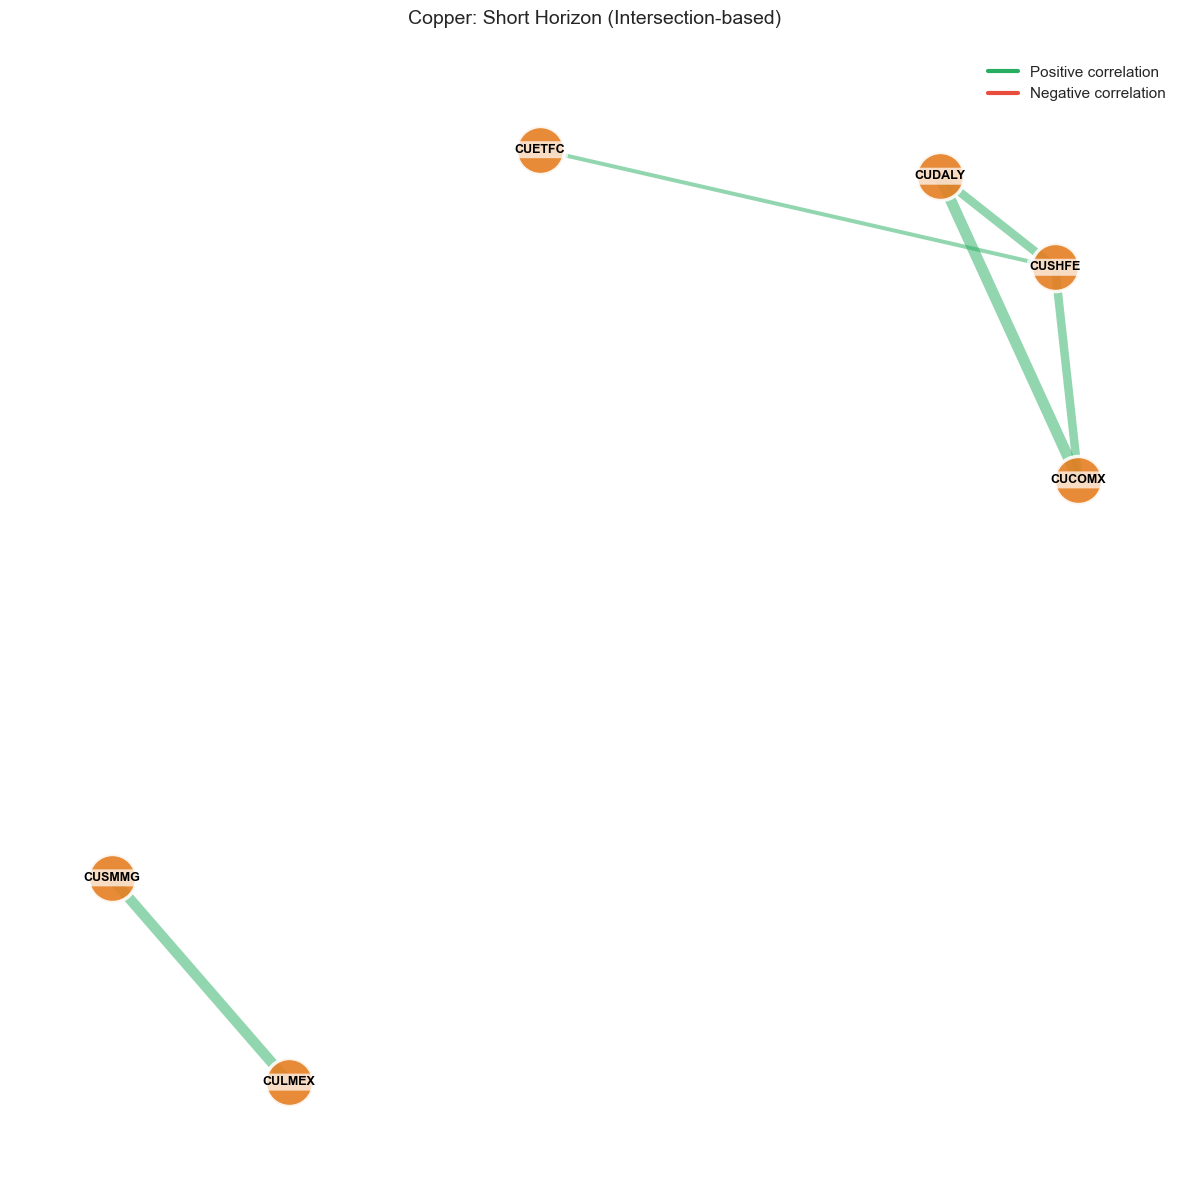

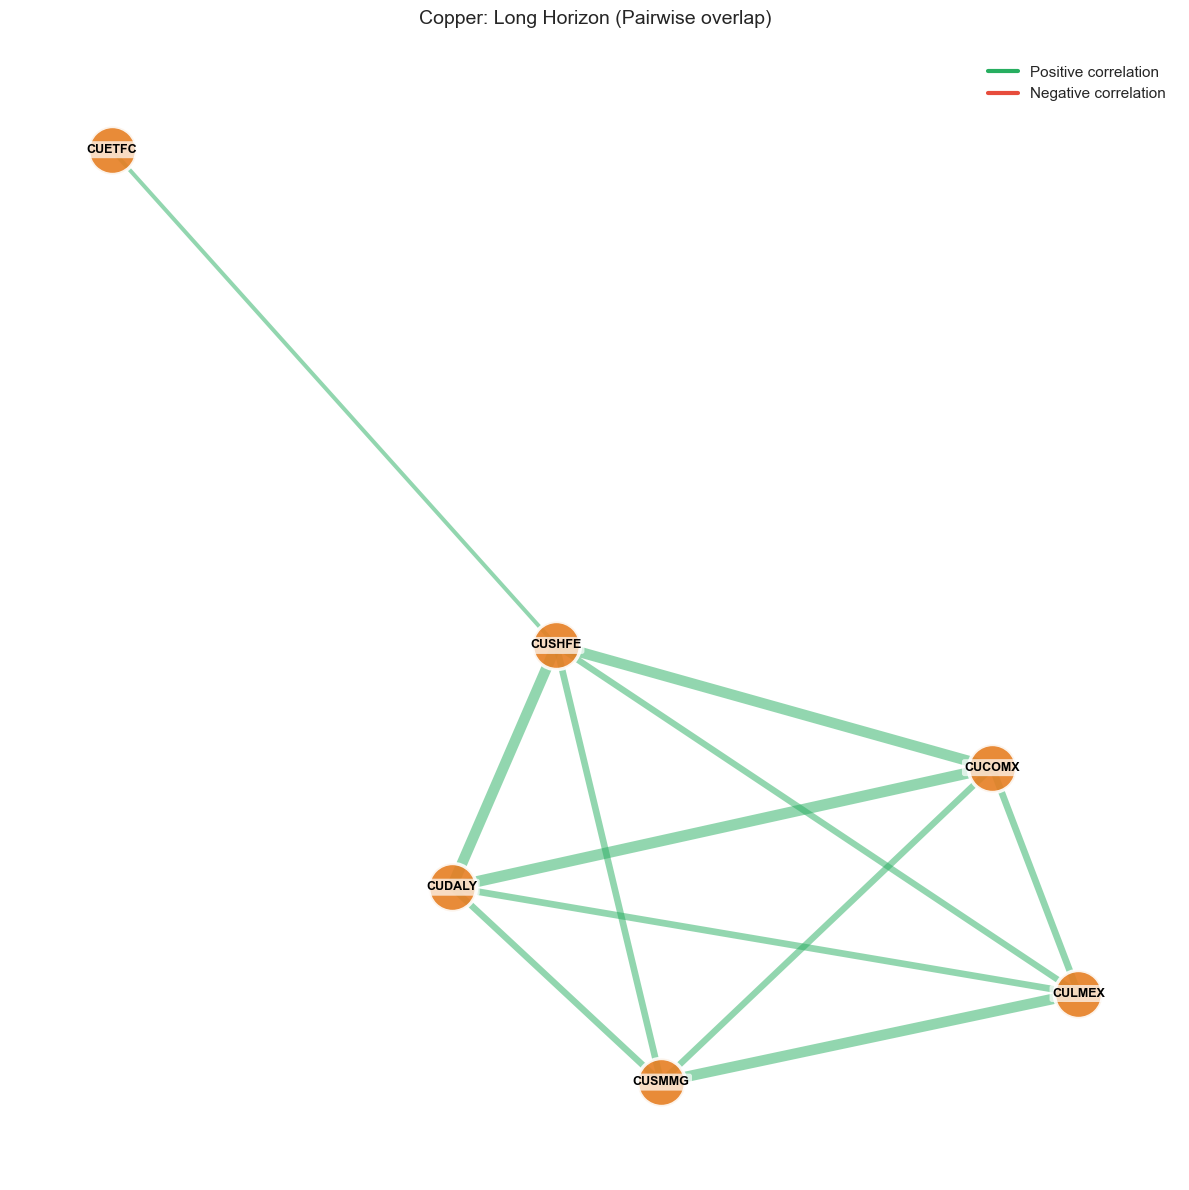

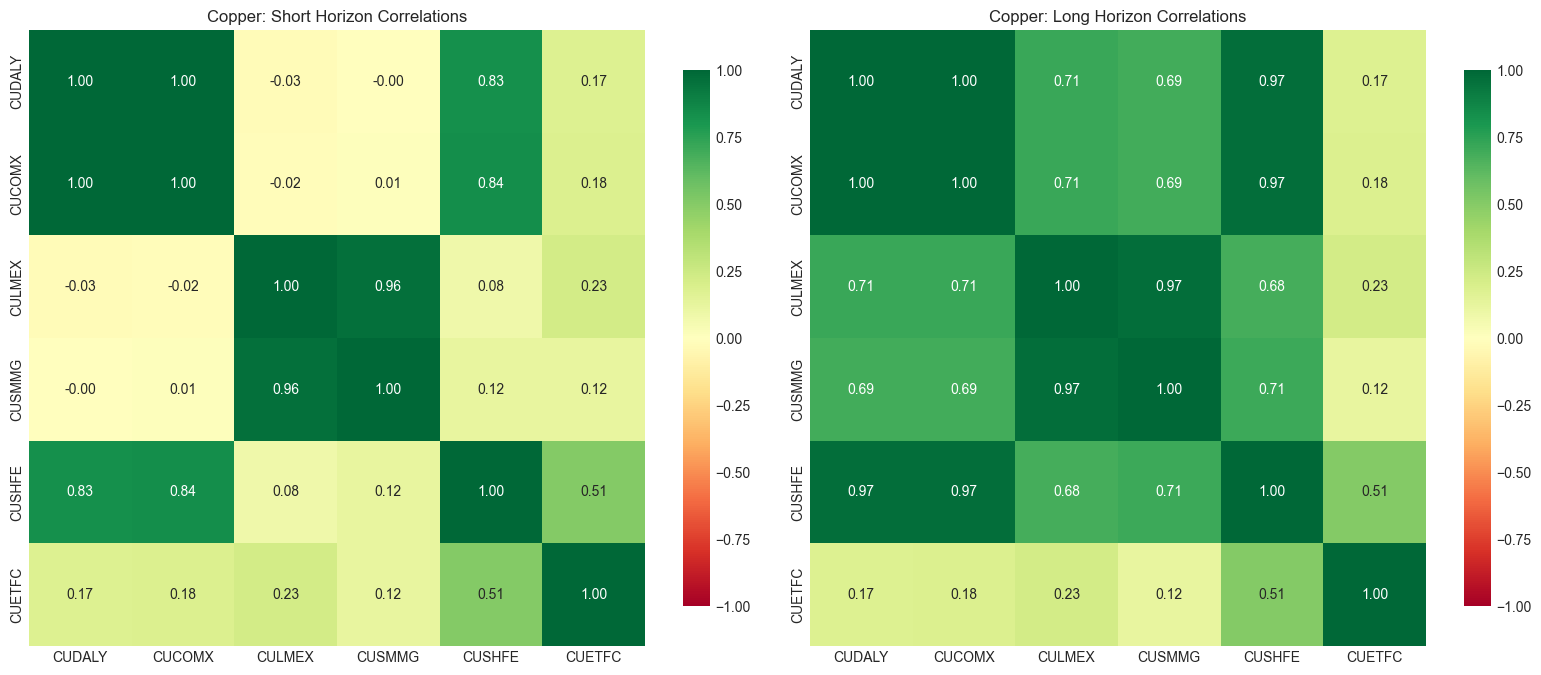

In [7]:
# Visualizations for Copper
print("\n" + "="*60)
print("COPPER VISUALIZATIONS")
print("="*60 + "\n")

G_short = create_correlation_network(corr_short,
                                     f'{metal}: Short Horizon (Intersection-based)',
                                     color, threshold=0.3)

G_long = create_correlation_network(corr_long,
                                    f'{metal}: Long Horizon (Pairwise overlap)',
                                    color, threshold=0.3)

# Comparison heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_short, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title(f'{metal}: Short Horizon Correlations', fontsize=12)

sns.heatmap(corr_long, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title(f'{metal}: Long Horizon Correlations', fontsize=12)

plt.tight_layout()
plt.show()

### 3.3 Lithium

In [8]:
metal = 'Lithium'
color = '#27ae60'  # Green

print(f"{'='*60}")
print(f"  {metal.upper()} - CORRELATION ANALYSIS")
print(f"{'='*60}\n")

# Short horizon
print("SHORT HORIZON (Intersection-based)")
print("-" * 40)
df_short = intersection_data[metal].dropna()
print(f"Time range: {df_short.index.min()} to {df_short.index.max()}")
print(f"Observations: {len(df_short)}")
print(f"Series: {df_short.columns.tolist()}\n")

corr_short = compute_spearman_matrix(df_short)
print("Spearman correlation matrix (short horizon):")
print(corr_short.round(3))
print(f"\nMean correlation: {corr_short.values[np.triu_indices_from(corr_short.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_short.values[np.triu_indices_from(corr_short.values, k=1)]):.3f}\n")

# Long horizon
print("LONG HORIZON (Pairwise overlap)")
print("-" * 40)
df_long = full_data[metal]
print(f"Full dataset range: {df_long.index.min()} to {df_long.index.max()}")
print(f"Total rows: {len(df_long)}\n")

corr_long, overlap_counts = compute_pairwise_overlap_corr(df_long)
print("Spearman correlation matrix (long horizon - pairwise overlap):")
print(corr_long.round(3))
print(f"\nMean correlation: {corr_long.values[np.triu_indices_from(corr_long.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_long.values[np.triu_indices_from(corr_long.values, k=1)]):.3f}")

print("\nOverlap counts (observations per pair):")
print(overlap_counts)

  LITHIUM - CORRELATION ANALYSIS

SHORT HORIZON (Intersection-based)
----------------------------------------
Time range: 2023-10-02 00:00:00 to 2025-10-31 00:00:00
Observations: 556
Series: ['LIDALY', 'LICOMX', 'LILAMC', 'LIEALC', 'LIEABG', 'LILMEX']

Spearman correlation matrix (short horizon):
        LIDALY  LICOMX  LILAMC  LIEALC  LIEABG  LILMEX
LIDALY   1.000   0.853   0.617   0.892   0.891   0.833
LICOMX   0.853   1.000   0.599   0.912   0.911   0.940
LILAMC   0.617   0.599   1.000   0.528   0.532   0.529
LIEALC   0.892   0.912   0.528   1.000   0.993   0.892
LIEABG   0.891   0.911   0.532   0.993   1.000   0.889
LILMEX   0.833   0.940   0.529   0.892   0.889   1.000

Mean correlation: 0.787
Median correlation: 0.889

LONG HORIZON (Pairwise overlap)
----------------------------------------
Full dataset range: 2017-05-10 00:00:00 to 2025-12-09 00:00:00
Total rows: 2202

Spearman correlation matrix (long horizon - pairwise overlap):
        LIDALY  LISAME  LICOMX  LILAMC  LIEALC  


LITHIUM VISUALIZATIONS



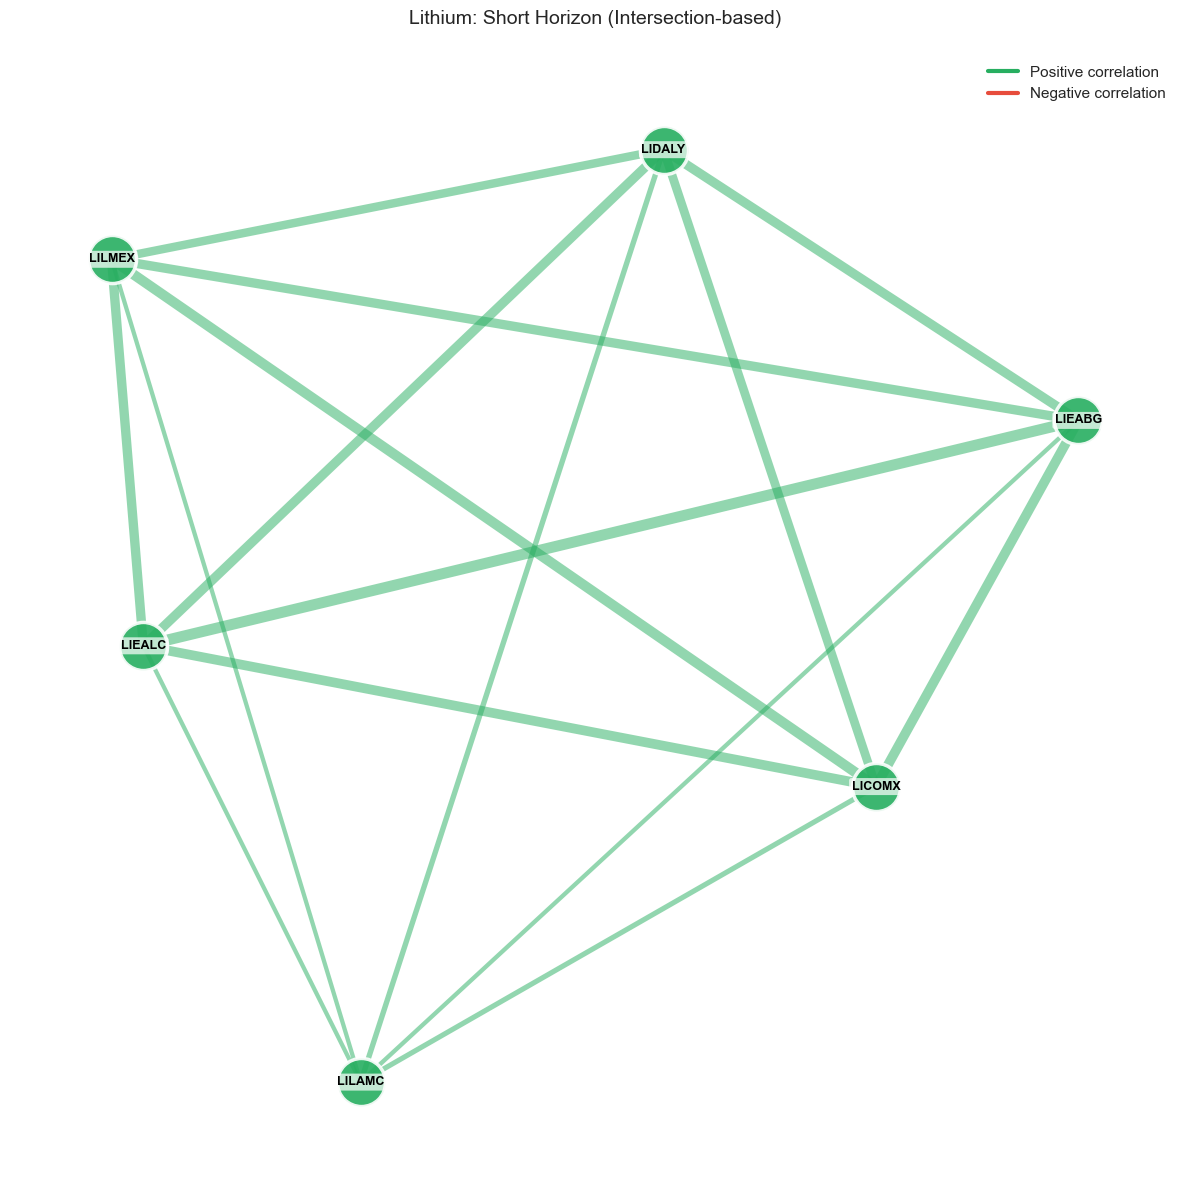

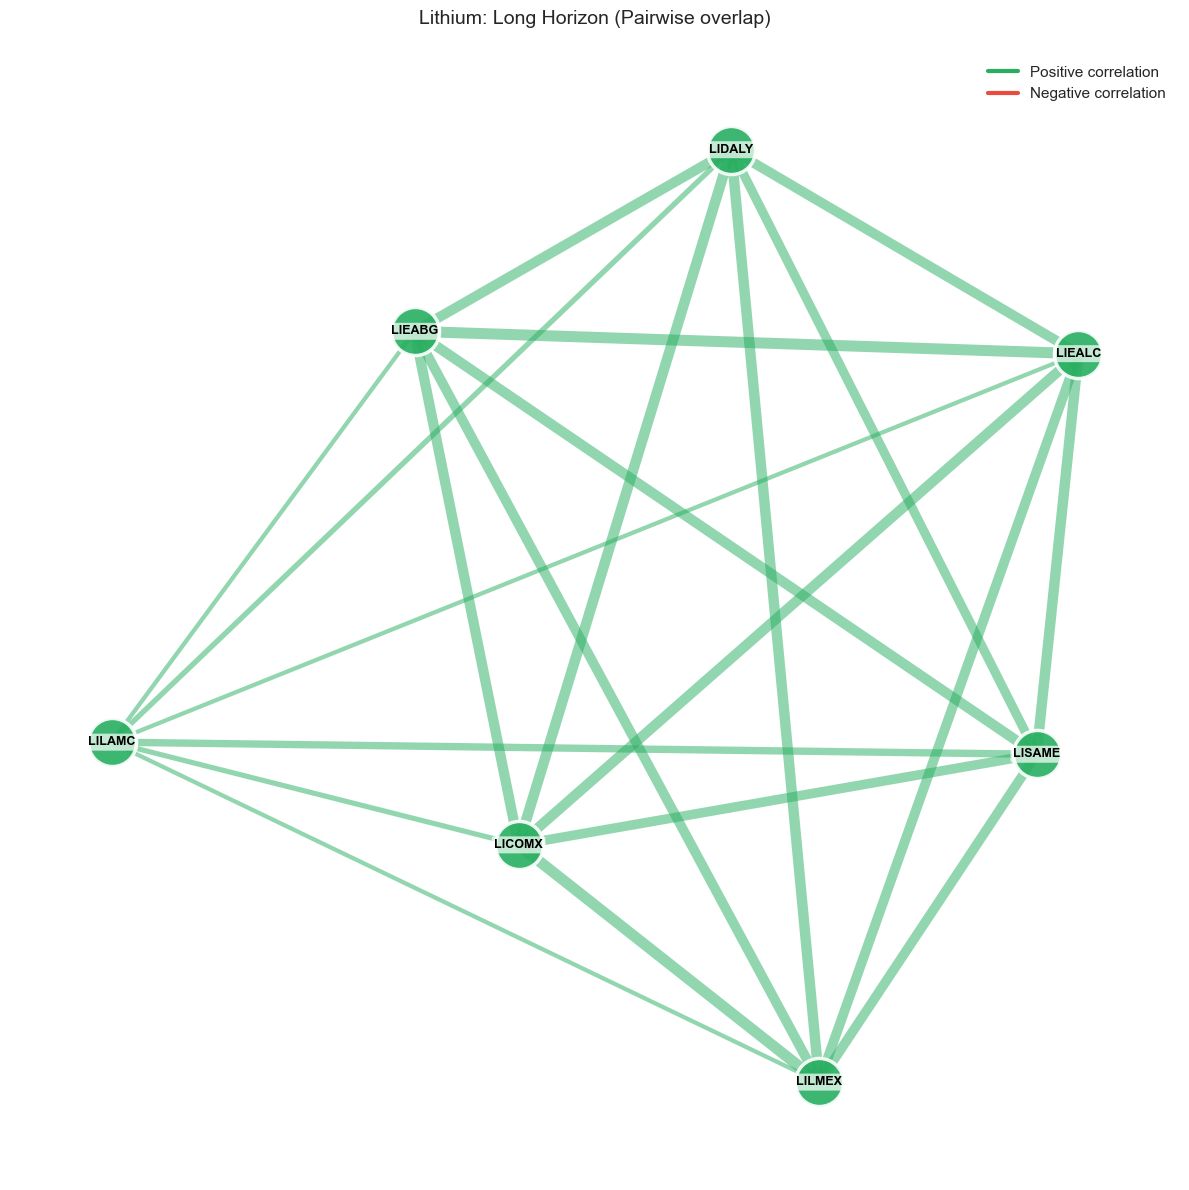

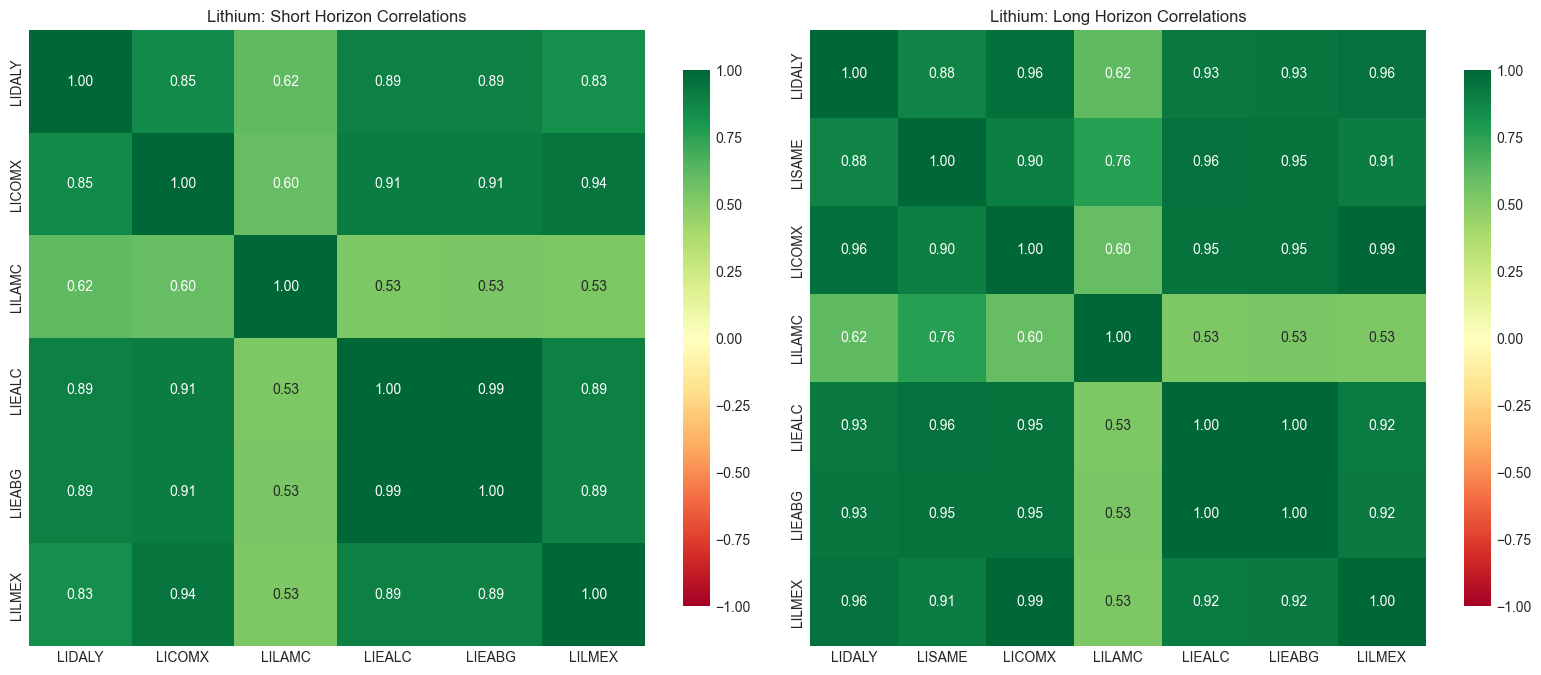

In [9]:
# Visualizations for Lithium
print("\n" + "="*60)
print("LITHIUM VISUALIZATIONS")
print("="*60 + "\n")

G_short = create_correlation_network(corr_short,
                                     f'{metal}: Short Horizon (Intersection-based)',
                                     color, threshold=0.3)

G_long = create_correlation_network(corr_long,
                                    f'{metal}: Long Horizon (Pairwise overlap)',
                                    color, threshold=0.3)

# Comparison heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_short, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title(f'{metal}: Short Horizon Correlations', fontsize=12)

sns.heatmap(corr_long, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title(f'{metal}: Long Horizon Correlations', fontsize=12)

plt.tight_layout()
plt.show()

### 3.4 Nickel

In [10]:
metal = 'Nickel'
color = '#9b59b6'  # Purple

print(f"{'='*60}")
print(f"  {metal.upper()} - CORRELATION ANALYSIS")
print(f"{'='*60}\n")

# Short horizon
print("SHORT HORIZON (Intersection-based)")
print("-" * 40)
df_short = intersection_data[metal].dropna()
print(f"Time range: {df_short.index.min()} to {df_short.index.max()}")
print(f"Observations: {len(df_short)}")
print(f"Series: {df_short.columns.tolist()}\n")

corr_short = compute_spearman_matrix(df_short)
print("Spearman correlation matrix (short horizon):")
print(corr_short.round(3))
print(f"\nMean correlation: {corr_short.values[np.triu_indices_from(corr_short.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_short.values[np.triu_indices_from(corr_short.values, k=1)]):.3f}\n")

# Long horizon
print("LONG HORIZON (Pairwise overlap)")
print("-" * 40)
df_long = full_data[metal]
print(f"Full dataset range: {df_long.index.min()} to {df_long.index.max()}")
print(f"Total rows: {len(df_long)}\n")

corr_long, overlap_counts = compute_pairwise_overlap_corr(df_long)
print("Spearman correlation matrix (long horizon - pairwise overlap):")
print(corr_long.round(3))
print(f"\nMean correlation: {corr_long.values[np.triu_indices_from(corr_long.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_long.values[np.triu_indices_from(corr_long.values, k=1)]):.3f}")

print("\nOverlap counts (observations per pair):")
print(overlap_counts)

  NICKEL - CORRELATION ANALYSIS

SHORT HORIZON (Intersection-based)
----------------------------------------
Time range: 2023-03-22 00:00:00 to 2025-07-21 00:00:00
Observations: 698
Series: ['NIDALY', 'NILMEX', 'NIETFN', 'NISHFE', 'NIWUXI', 'NIINDA']

Spearman correlation matrix (short horizon):
        NIDALY  NILMEX  NIETFN  NISHFE  NIWUXI  NIINDA
NIDALY   1.000   0.988   0.878   0.956   0.959   0.959
NILMEX   0.988   1.000   0.901   0.965   0.968   0.972
NIETFN   0.878   0.901   1.000   0.864   0.849   0.883
NISHFE   0.956   0.965   0.864   1.000   0.982   0.967
NIWUXI   0.959   0.968   0.849   0.982   1.000   0.954
NIINDA   0.959   0.972   0.883   0.967   0.954   1.000

Mean correlation: 0.936
Median correlation: 0.959

LONG HORIZON (Pairwise overlap)
----------------------------------------
Full dataset range: 2016-04-04 00:00:00 to 2025-11-18 00:00:00
Total rows: 2857

Spearman correlation matrix (long horizon - pairwise overlap):
        NIDALY  NILMEX  NIETFN  NISHFE  NIWUXI  N


NICKEL VISUALIZATIONS



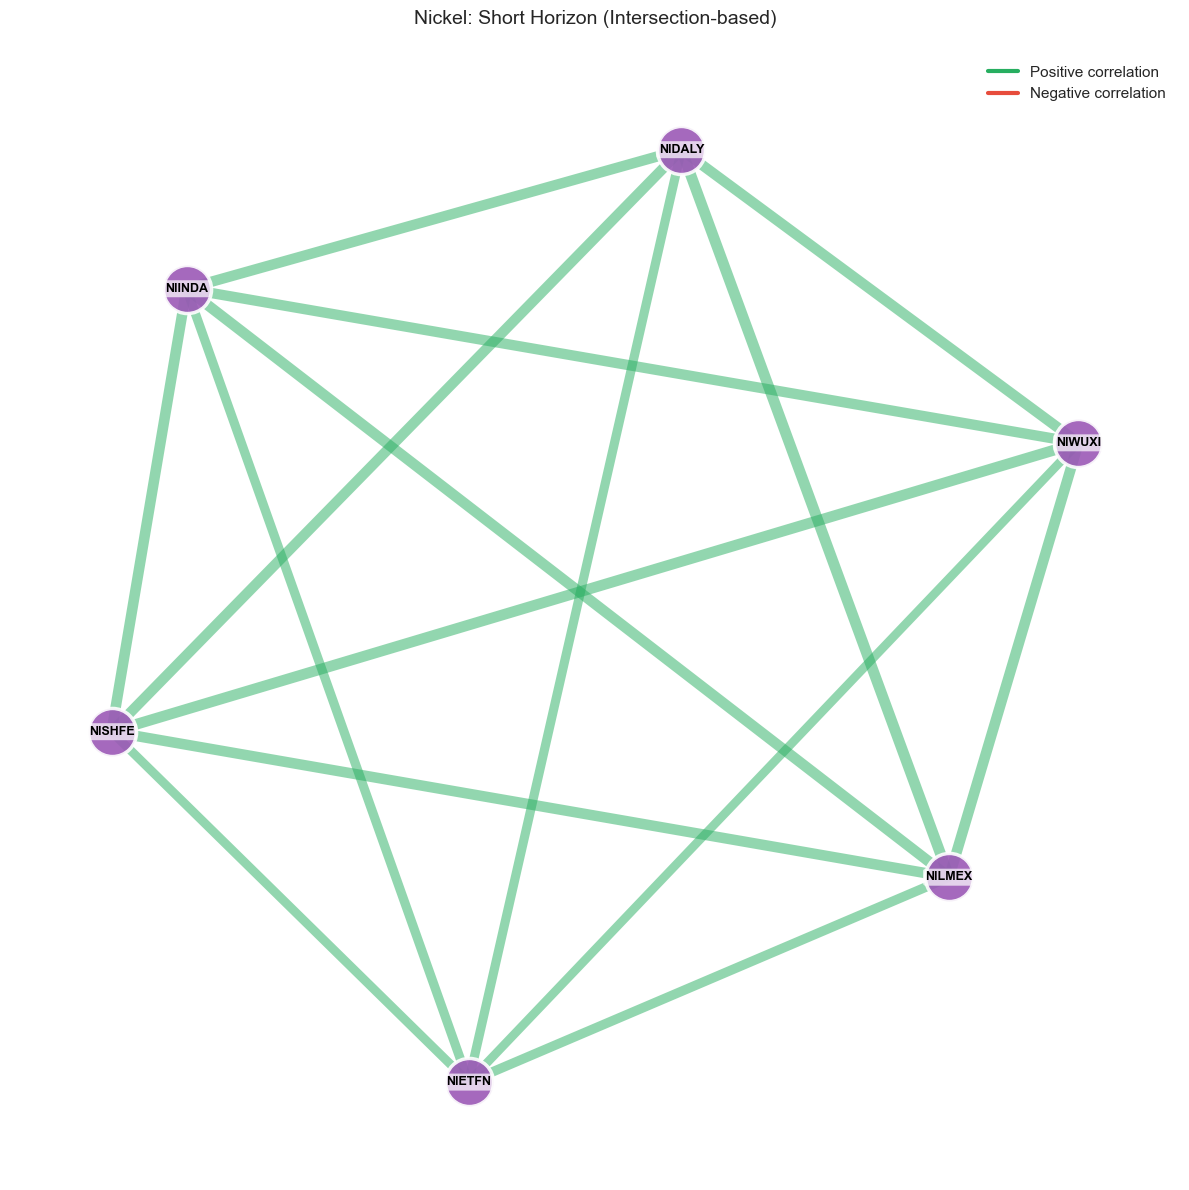

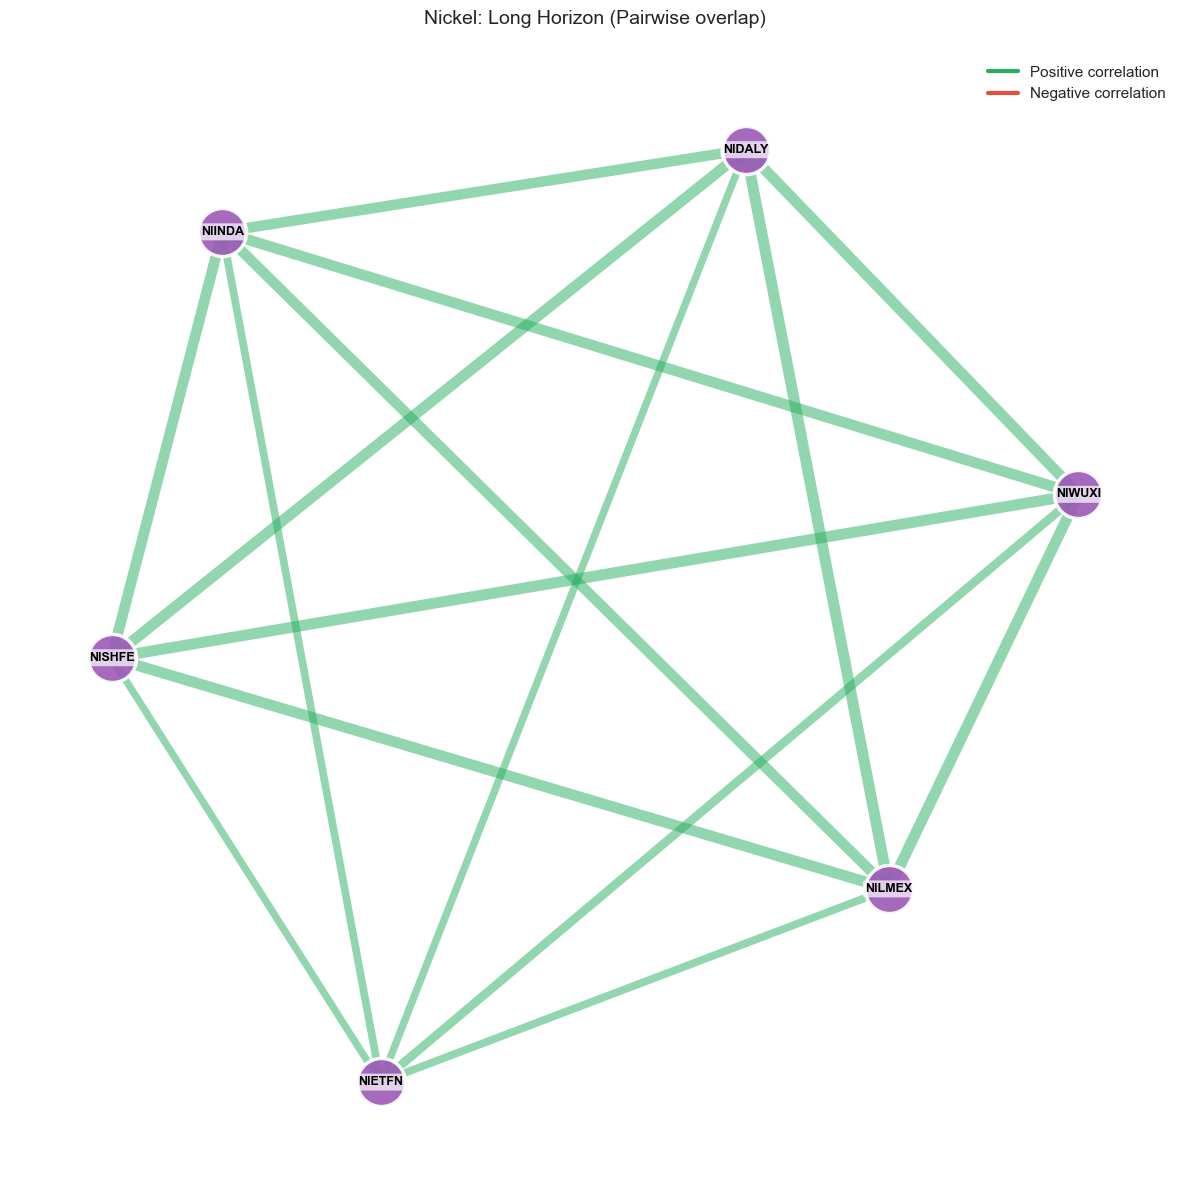

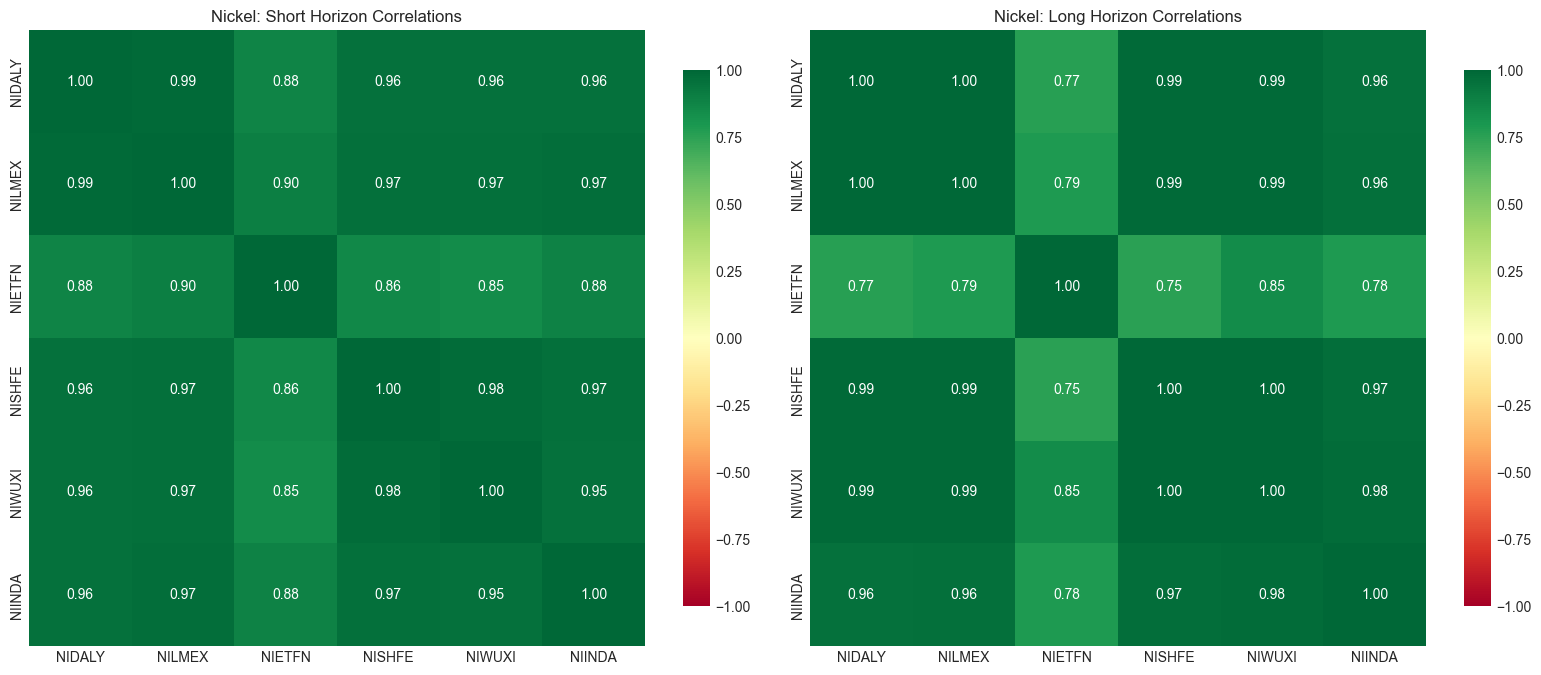

In [11]:
# Visualizations for Nickel
print("\n" + "="*60)
print("NICKEL VISUALIZATIONS")
print("="*60 + "\n")

G_short = create_correlation_network(corr_short,
                                     f'{metal}: Short Horizon (Intersection-based)',
                                     color, threshold=0.3)

G_long = create_correlation_network(corr_long,
                                    f'{metal}: Long Horizon (Pairwise overlap)',
                                    color, threshold=0.3)

# Comparison heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_short, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title(f'{metal}: Short Horizon Correlations', fontsize=12)

sns.heatmap(corr_long, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title(f'{metal}: Long Horizon Correlations', fontsize=12)

plt.tight_layout()
plt.show()

## 4. Key Insights

**Time Horizon Effects:**

1. **Short horizon (intersection-based)**:
   - Uses only the common time period where all series overlap
   - May have fewer observations but ensures temporal alignment
   - Reflects correlation structure during the shared period
   - More suitable for comparing contemporaneous relationships

2. **Long horizon (pairwise overlap)**:
   - Maximizes data usage by using full overlap for each pair
   - Different pairs may be correlated over different time periods
   - Can capture longer-term relationships
   - May include different market regimes for different pairs

**Expected Differences:**

- Correlations may be **stronger** in short horizon if the common period represents a stable market regime
- Correlations may be **weaker** if the common period includes high volatility or structural breaks
- Long horizon correlations may **differ significantly** if series have different active periods with distinct market conditions
- The overlap count matrix reveals which pairs have more historical data available

**Interpretation:**

- Large differences between short and long horizon suggest **time-varying correlation structures**
- Similar correlations across horizons indicate **stable relationships**
- Network topology changes reveal which series pairs are **regime-dependent** vs **structurally linked**